In [55]:
import numpy as np 
import matplotlib.pyplot as plt
np.random.seed(40)

""""
Parameters used :
r : risk free rate 
sigma : volatility of the stock 
X0 : initial stock price
T : maturity date
n : number of simulation 
m : step in Euler scheme
A reverse convertible can be seen as a short down an in put (barrier option) and a guaranteed coupon received at maturity.
"""

r,sigma,X0,T,n,m = 0 , 0.2 , 100 , 1 , 10**4, 100 

"""
Parameters of the DI Put option and the coupon :

K : strike of the put option (usually ATM)
H : barrier (usually 50-80% of X0)
C : coupon rate (usually 6%)
P : principal invested
"""
K , H , C , P = 100 , 80 , 0.1 , 100

#reverse convertible = short down and in put + guaranted coupon 
# payoff reverse convertible= -(K-S_T)+*indatrice(min(St)<=H) + C 

In [56]:
# Function to generate paths using the Euler-Maruyama method
def Euler_X(X0=100, sigma=0.2, T=1, m=100, n=10**4, W=None):
    if W is None:
        W = np.random.randn(n, m)
    return X0 * np.cumprod(1 + r * T/m + sigma * np.sqrt(T/m) * W, axis=1)

# Function to estimated the price of the option by Monte Carlo simulations
def MC_RCbarrier(X0=100, sigma=0.2, T=1, K=100, H=50, C=0.1, P=100, m=100, n=10**4, W=None):
    if W is None:
        W = np.random.randn(n, m)
    X = Euler_X(X0, sigma, T, m, n, W) # Simulations of the n Black-Scholes paths of the underlying
    X = np.hstack((X0 * np.ones((n, 1)), X))
    min_X = np.min(X, axis=1)
    payoff_arr = -(np.maximum(K - X[:, -1], 0) * (min_X <= H)) + (1+P)*C # Payoff of the RC_barrier for each simulation
    estimator = np.mean(payoff_arr * np.exp(-r * T)) # Price estimator = discounted expectation of the payoff
    std_error = np.std(payoff_arr) / np.sqrt(n) # Standard error of the MC estimator
    return estimator, std_error


estim_1, std_error_1 = MC_RCbarrier()
print("Estimator for m = 100 : ", estim_1)
print("Confidence interval for m = 100 : [", estim_1 - 1.96*std_error_1, " ; ", estim_1 + 1.96*std_error_1, "].")

Estimator for m = 100 :  10.07422730965395
Confidence interval for m = 100 : [ 10.051626233036275  ;  10.096828386271623 ].


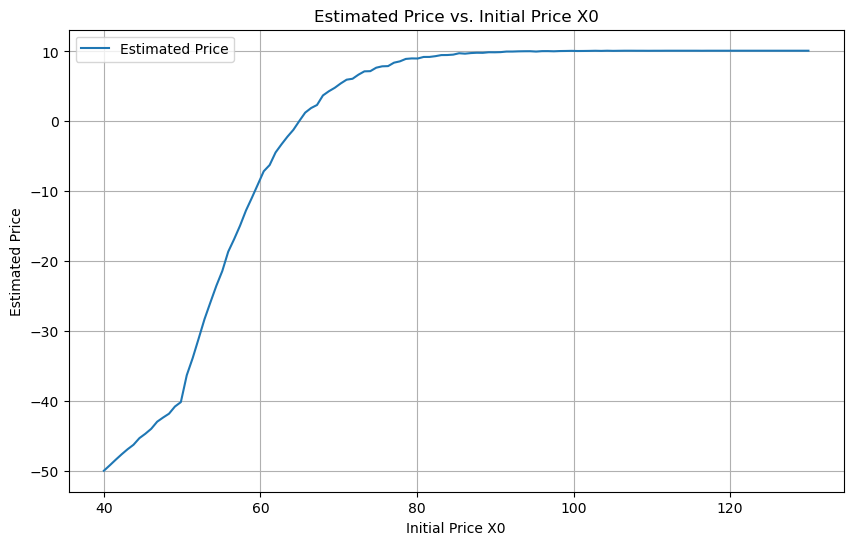

In [81]:
# Values of X0 to consider
X0_values = np.linspace(40, 130, 120)

# Calculate the estimated price for each X0
estimates = [MC_RCbarrier(X0=element)[0] for element in X0_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X0_values, estimates, label='Estimated Price')
plt.title('Estimated Price vs. Initial Price X0')
plt.xlabel('Initial Price X0')
plt.ylabel('Estimated Price')
plt.legend()
plt.grid(True)
plt.show()

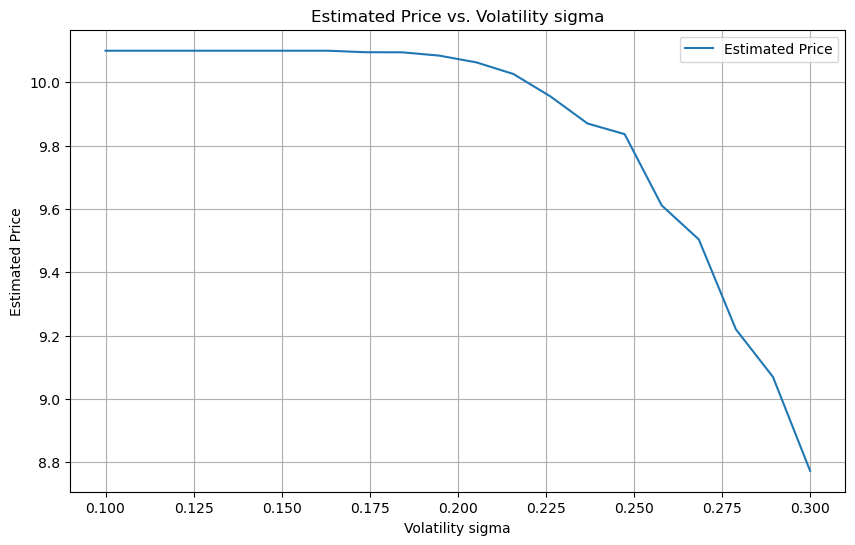

In [78]:
# Values of sigma to consider
sigma_values = np.linspace(0.1, 0.3, 20)

# Calculate the estimated price for each sigma
estimates = [MC_RCbarrier(sigma=element)[0] for element in sigma_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sigma_values, estimates, label='Estimated Price')
plt.title('Estimated Price vs. Volatility sigma')
plt.xlabel('Volatility sigma')
plt.ylabel('Estimated Price')
plt.legend()
plt.grid(True)
plt.show()

In [89]:
def calculate_delta(X0=100, sigma=0.2, T=1, K=100, H=50, C=0.1, P=100, m=100, n=10**4, delta_X=1, W=None):
    if W is None:
        W = np.random.randn(n, m)
    price_up = MC_RCbarrier(X0+delta_X, sigma, T, K, H, C, P, m, n, W)[0]
    price_down = MC_RCbarrier(X0-delta_X, sigma,  T, K, H, C, P, m, n, W)[0]
    return (price_up - price_down) / (2 * delta_X)

def calculate_gamma(X0=100, sigma=0.2, T=1, K=100, H=50, C=0.1, P=100, m=100, n=10**4, delta_X=1, W=None):
    if W is None:
        W = np.random.randn(n, m)
    price_up = MC_RCbarrier(X0+delta_X, sigma, T, K, H, C, P, m, n, W)[0]
    price_down = MC_RCbarrier(X0-delta_X, sigma,  T, K, H, C, P, m, n, W)[0]
    base_price = MC_RCbarrier(X0, sigma,  T, K, H, C, P, m, n, W)[0]
    return (price_up - 2 * base_price + price_down) / (delta_X ** 2)

def calculate_vega(X0=100, sigma=0.2, T=1, K=100, H=50, C=0.1, P=100, m=100, n=10**4, delta_sigma=0.05, W=None):
    if W is None:
        W = np.random.randn(n, m)
    base_price = MC_RCbarrier(X0, sigma, T, K, H, C, P, m, n, W)[0]
    price_vol_up = MC_RCbarrier(X0, sigma+delta_sigma, T, K, H, C, P, m, n, W)[0]
    return (price_vol_up - base_price) / delta_sigma


In [83]:
Z = np.random.randn(n, m)

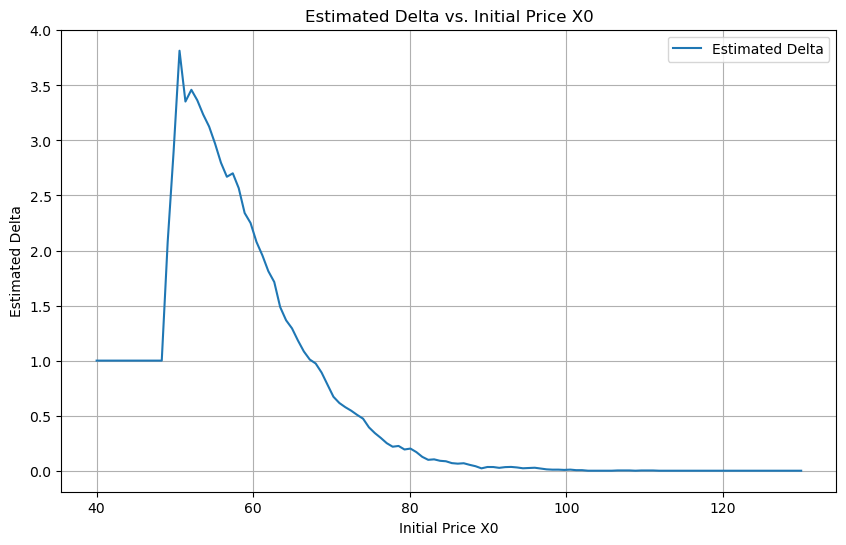

In [84]:
# Calculate the estimated Delta for each X0
deltas = [calculate_delta(X0=element, W=Z) for element in X0_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X0_values, deltas, label='Estimated Delta')
plt.title('Estimated Delta vs. Initial Price X0')
plt.xlabel('Initial Price X0')
plt.ylabel('Estimated Delta')
plt.legend()
plt.grid(True)
plt.show()

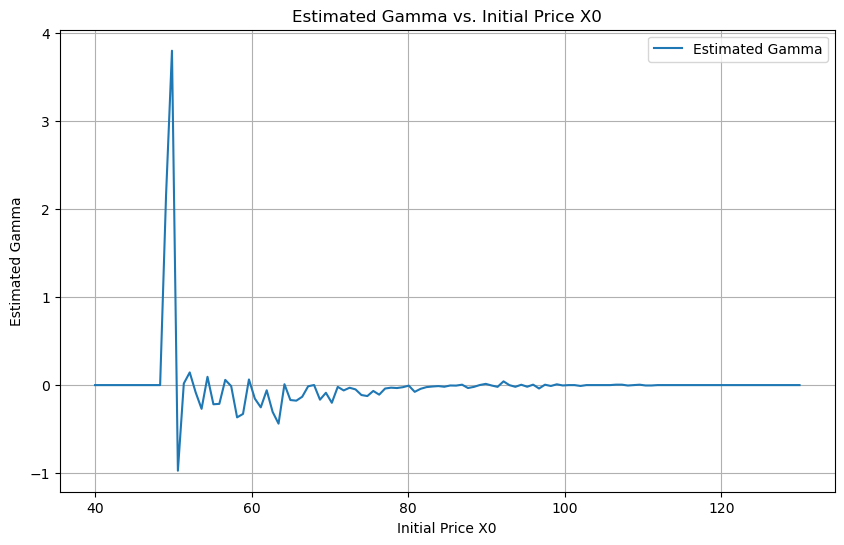

In [85]:
# Calculate the estimated Delta for each X0
gammas = [calculate_gamma(X0=element, W=Z) for element in X0_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X0_values, gammas, label='Estimated Gamma')
plt.title('Estimated Gamma vs. Initial Price X0')
plt.xlabel('Initial Price X0')
plt.ylabel('Estimated Gamma')
plt.legend()
plt.grid(True)
plt.show()

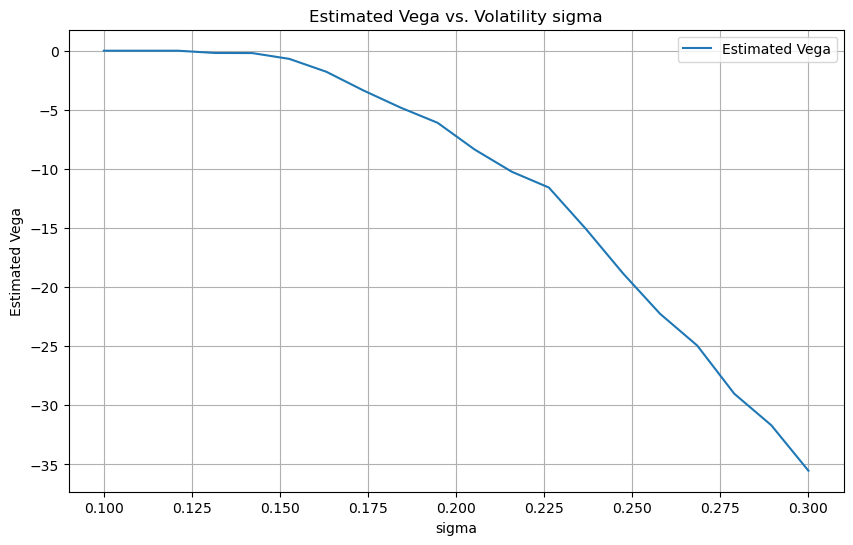

In [90]:
# Calculate the estimated vega for each sigma
vegas = [calculate_vega(sigma=element, W=Z) for element in sigma_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sigma_values, vegas, label='Estimated Vega')
plt.title('Estimated Vega vs. Volatility sigma')
plt.xlabel('sigma')
plt.ylabel('Estimated Vega')
plt.legend()
plt.grid(True)
plt.show()